# CONTEXTO DO PROBLEMA

A Blocker Fraude Company é uma empresa especializada na detecção de fraudes em transações financeiras feitas através de dispositivos móveis. A empresa tem um serviço chamado “Blocker Fraud” no qual garante o bloqueio de transações fraudulentas.

E o modelo de negócio da empresa é do tipo Serviço com a monetização feita por performance do serviço prestado, ou seja, o usuário paga uma taxa fixa sobre o sucesso na detecção de fraude das transações do cliente.

Porém, a Blocker Fraud Company está em fase de expansão no Brasil e para adquirir clientes mais rapidamente, ela adotou uma estratégia muito agressiva. A estratégia funciona da seguinte forma:

1. A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.
2. A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.
3. A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.


Com essa estratégia agressiva a empresa assume os riscos em falhar na detecção de fraude e é remunerada na detecção assertiva das fraudes.

Para o cliente, é um excelente negócio contratar a Blocker Fraud Company. Apesar da taxa cobrada ser muito alta sobre o sucesso, 25%, a empresa reduz seus custos com transações fraudulentas detectadas corretamente e ainda o prejuízo causado por um erro do serviço de anti-fraude será coberto pela própria Blocker Fraud Company.

Para a empresa, além de conseguir muitos clientes com essa estratégia arriscada em garantir o reembolso no caso de uma falha na detecção de fraude do cliente, ela depende somente da precisão e da acurácia dos modelos construídos pelos seus Cientistas de Dados, ou seja, quanto mais preciso for o modelo “Blocker Fraud”, maior o faturamento da empresa. Porém, se o modelo tiver baixa precisão, a empresa poderá ter um prejuízo enorme.

# O PROBLEMA

Você foi contratado como um Consultor de Ciência de Dados para criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

Ao final da sua consultoria, você precisa entregar ao CEO da Blocker Fraud Company um modelo em produção no qual seu acesso será feito via API, ou seja, os clientes enviarão suas transações via API para que o seu modelo as classifique como fraudulentas ou legítimas.

Além disso, você precisará entregar um relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu. No seu relatório deve conter as respostas para as seguintes perguntas:

1. Qual a Precisão e Acurácia do modelo?
2. Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
3. Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
4. Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
5. Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

# ENTENDIMENTO DO PROBLEMA

**Motivação:** Alta estratégia de crescimento para expansão sobre os resultados de detecção das fraudes.

**Causa Raiz do Problema:** Criar um modelo capaz de detectar fraudes com alta acuracia.

**Tipo de Problema:** Detecção de Fraude.

**Potênciais Métodos:** Classificação.

**Granularidade:** Classificação de Fraude por Transação.

**Entraga da Solução:** WebApp contendo a predição e o Relatório.

**Dados para Resolver o Problema:** [Kaggle](https://www.kaggle.com/ealaxi/paysim1).

# 0.0 IMPORTS

In [1]:
# Manipulation
import pandas as pd
import inflection

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# math and statistic
import numpy as np
from scipy import stats

# preparation ML
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

## 0.1 Funções Auxiliares

In [2]:
# correlation categories
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# Show matrix correlation
def show_matrix(col, data, output='list'):

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])
    
    
def plot_boxplot(x1, x2, x3, data):
    
    """
    A função recebe 3 series.
    Retorna 3 plot de boxplot nas mesma linha.
    """
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.boxplot(x=x1)
    
    plt.subplot(1, 3, 2)
    sns.boxplot(x=x2)
    
    plt.subplot(1, 3, 3)
    sns.boxplot(x=x3)
    
    
def low_variance(data, threshold):
    
    variance_list = []
    columns_list = []
    color = []
    variance = 0
    
    for p in range(data.shape[1]):
        
        variance = data.iloc[:, p].var() # calculate variance
    
        variance_list.append(variance) # variance
        columns_list.append(data.columns[p]) # columns
        
        if variance >= threshold:
            color.append('green')
            
        else:
            color.append('blue')
            
    df = pd.DataFrame({'columns': columns_list, 'variance': variance_list, 'color': color})
    df = df.sort_values(by='variance', ascending=False)
    sns.barplot(x='variance', y='columns', data=df, palette=list(df['color'].values))

## 0.2 Carregamento de Dados

In [3]:
df = pd.read_csv('../data/fraud_data.csv') # load data

df.head() # show data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [4]:
print(f'Qty. Rows: {df.shape[0]}')
print(f'Qty. Columns: {df.shape[1]}')

Qty. Rows: 6362620
Qty. Columns: 11


## 1.2 Renomeação de Colunas

In [5]:
# Snakecase
snakecase = lambda x: inflection.underscore(x)

# Alter name columns
df.columns = list(map(snakecase, list(df.columns)))
df.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Tipo de Dados

In [6]:
df.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

## 1.4 Verificação de Dados Ausentes

In [7]:
df.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.5 Mudança do Tipo de Dados

## 1.6 Estatística Descritiva

### 1.6.1 Atributos Numéricos

In [8]:
numerical = df.select_dtypes(include=['int64', 'float64'])  # Select numerical data
describe = numerical.describe().T  # describe data

describe['kurtosis'] = numerical.apply(lambda x: x.kurtosis())  # add kurtosis in describe
describe['skew'] = numerical.apply(lambda x: x.skew())  # add skew in describe

describe

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,0.329071,0.375177
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,1797.956705,30.993949
oldbalance_org,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,32.964879,5.249136
newbalance_orig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,32.066985,5.176884
oldbalance_dest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,948.674125,19.921758
newbalance_dest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,862.156508,19.352302
is_fraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00,769.702982,27.779538
is_flagged_fraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00,397659.062500,630.603629


**Insight:**

<ins>Distribuição</ins>: Há pessoas que fizeram transação com valor de 0 no total, e pessoas que fizeram transação sem dinheiro na conta. O valor máximo de uma transação foi de 92 milhões, um range de transações muito grande.No geral todas as variaveis numéricas estão com um range grande com valores muito altos e nenhuma está seguindo uma distribuição normal.

<ins>Negócio</ins>: A média do valor das transações é de 100 mil, valores extremos aumentaram o valor da transação média. 50% das transações são feitas em cerca de 74 mil e 50% das contas de quem fez a transação restou 14 mil de saldo final. Em relação a fraude, mias de 75% dos casos são de transações legais e dentro do padrão. 

### 1.6.2 Atributos Categóricos

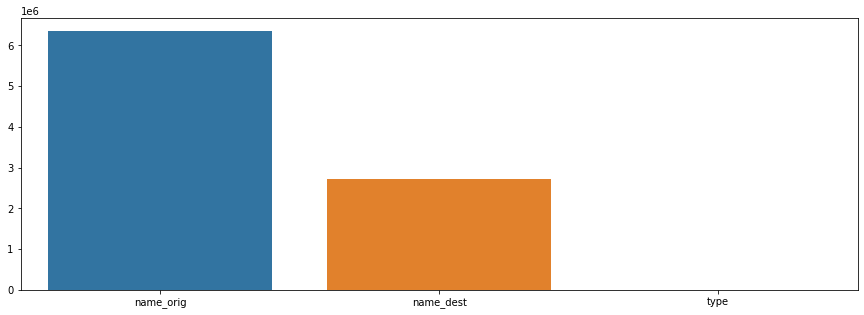

In [9]:
# Select categorical data
categorical = df.select_dtypes(include=['object'])

# Count unique values 
values_cat = categorical.apply(lambda x: len(x.unique())).sort_values(ascending=False)

# Figure
plt.figure(figsize=(15, 5))
sns.barplot(x=values_cat.index, y=values_cat.values);

**Insight:**

Os atributos categóricos possuem um grande range de possíveis valores, com exceção do tipo da transação.

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="../img/mind_map.png" width="1000" title="mind-map">
</p>

## 2.2 Hipóteses

### 2.2.1 Hipóteses Período

**1.** Fraudes acontecem mais no final de semana.

**2.** Fraudes acontecem mais em época de Black Friday.

**3.** Fraudes acontecem mais em feriados.

### 2.2.2 Hipóteses Transação

**1.** Fraudes acontecem mais em pagamentos de crédito.

**2.** Transações maiores que 50% do saldo bancario são fraudes.

**3.** A maior parte de transações feitas superior que 80mil, são fraudes.

**4.** Contas de origem que ficaram zeradas após as transações, são fraudes.

### 2.2.3 Hipóteses Cliente

**1.** Há maior quantidade de fraudes em contas de pessoas físicas.

**2.** Há maior quantidade de fraudes em contas de pessoas com alto poder aquisitivo.

**3.** Há maior quantidade de fraudes em transações de pessoa física para juridica.

## 2.3 Lista Final de Hipóteses

**1.** Fraudes acontecem mais em pagamentos de crédito.

**2.** Transações maiores que 50% do saldo bancario são fraudes.

**3.** A maior parte de transações feitas superior que 80mil, são fraudes.

**4.** Contas de origem que ficaram zeradas após as transações, são fraudes.

**5.** Há maior quantidade de fraudes em contas de pessoas físicas.

**6.** Há maior quantidade de fraudes em contas de pessoas com alto poder aquisitivo.

**7.** Há maior quantidade de fraudes em transações de pessoa física para juridica.

## 2.3 Feature Engineering

In [9]:
# Copy dataframe
df2 = df.copy()

# greater_50 - describe if the transaction is greater than 50% of the balance (yes or no)
df2['greater_50%'] = df2[['amount', 'oldbalance_org']].apply(
    lambda x: 'yes' if x['amount'] / 2 > x['oldbalance_org'] else 'no', axis=1
    )

# purchasing_power_org - describe the purchasing power of the origin transaction
average_salary = 3400
median_salary = df2['oldbalance_org'].median()

df2['purchasing_power_org'] = df2['oldbalance_org'].apply(
    lambda x: 'low' if x <= average_salary else 'average' 
                    if x > average_salary and x <= median_salary else 'high'
                )

# type_transaction - describe the type of transaction C = Customer and M = Merchants
df2['type_transaction'] = df2[['name_orig', 'name_dest']].apply(
    lambda x: 'C to C' if x['name_orig'][0] == 'C' and x['name_dest'][0] == 'C' else 'M to M' 
                       if x['name_orig'][0] == 'M' and x['name_dest'][0] == 'M' else 'C to M' 
                       if x['name_orig'][0] == 'C' and x['name_dest'][0] == 'M' else 'M to C' 
                       if x['name_orig'][0] == 'M' and x['name_dest'][0] == 'C' else None, axis=1
                    )

# type_amount - Describe is amount is greater than 80K (greater or less)
df2['type_amount'] = df2['amount'].apply(lambda x: 'greater' if x > 80000 else 'less')

# 3.0 FILTRAGEM DE DADOS

## 3.1 Filtragem de Linhas

## 3.2 Filtragem de Colunas

# 4.0 EDA

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

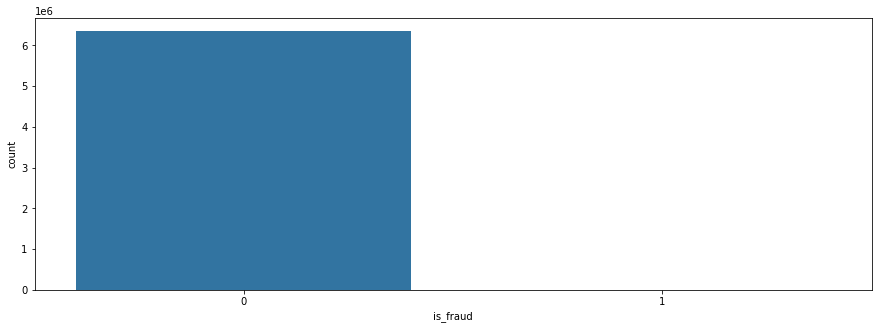

In [10]:
# Copy dataframe
df4 = df2.copy()

# Figure 
plt.figure(figsize=(15, 5))
sns.countplot(x='is_fraud', data=df4);

**Insight:**

Apenas 1º das transações são de fraude e 99% normais. Há um alto desbalanceamento de dados, visto que há um numero muito pequeno de fraudes.

### 4.1.2 Variável Numérica

#### 4.1.2.1 Distribuição

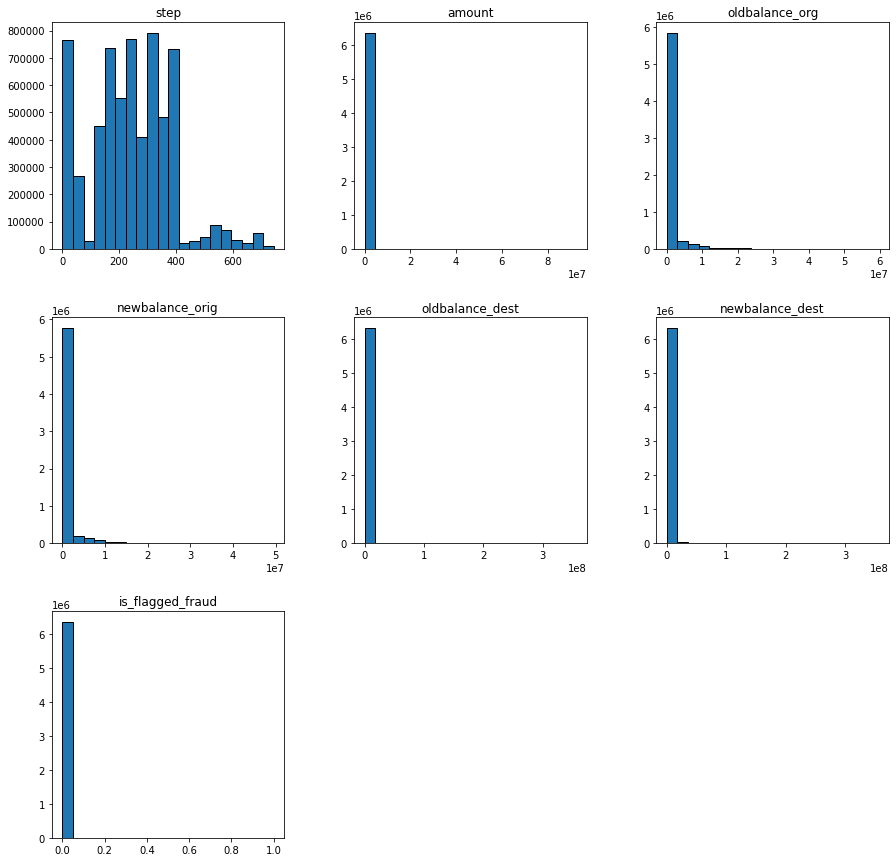

In [12]:
# Filter numerical atributes
num = df4.select_dtypes(include=['int64', 'float64']).drop(columns=['is_fraud'])

# Figure
num.hist(grid=False, bins=20, ec='k', figsize=(15, 15));

**Insight:**

No geral, as variavies numéricas não possuem tanto comportamento, estão com as distribuições mais concentradas em torno do zero, devido a possuir alta quantidade de informações com zero, deslocando as distribuições para a esquerda com um alto pico. A exceção é o atributo <ins>step</ins> que há maior comportamento e posui uma distribuição maior em valores entre 0 a 400. Os atributos estão longe de uma distribuição normal.

#### 4.1.2.2 Outliers

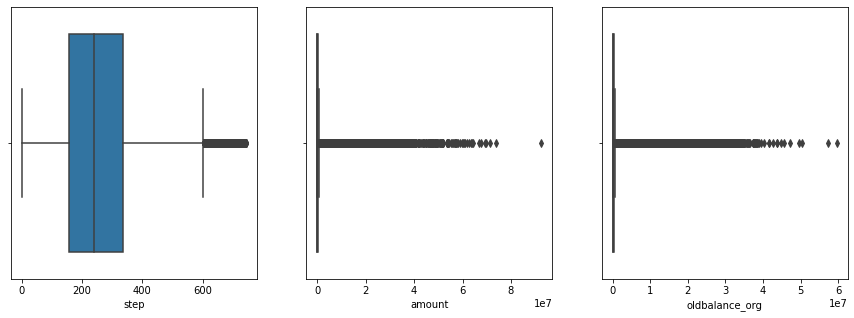

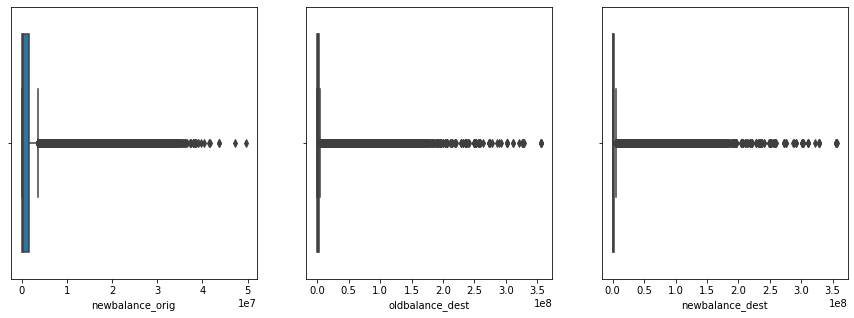

In [13]:
# Drop column
num = num.drop(columns='is_flagged_fraud')

# Filter values 
amount = num[num['amount'] > 1]['amount']
oldbalance_org = num[num['oldbalance_org'] > 1]['oldbalance_org']
newbalance_orig = num[num['newbalance_orig'] > 1]['newbalance_orig']
oldbalance_dest = num[num['oldbalance_dest'] > 1]['oldbalance_dest']
newbalance_dest = num[num['newbalance_dest'] > 1]['newbalance_dest']

# Create figures
plot_boxplot(x1=num['step'], x2=amount, x3=oldbalance_org, data=num)
plot_boxplot(x1=newbalance_orig, x2=oldbalance_dest, x3=newbalance_dest, data=num)

**Insight:**

### 4.1.3 Variável Categórica

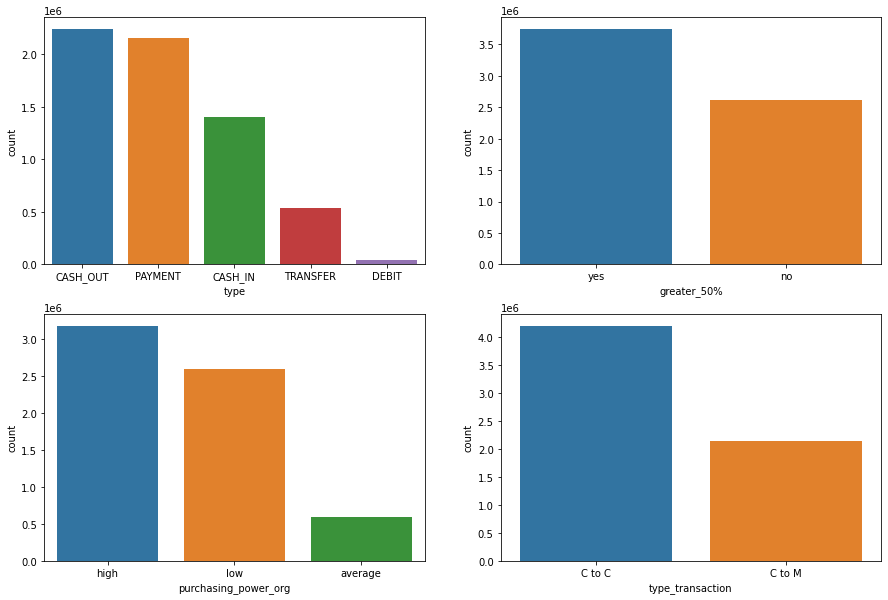

In [14]:
# Filter categorical atributes
cat = df4.select_dtypes(include=['object'])

# Figure 1
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.countplot(x='type', data=cat, order=list(cat['type'].value_counts().sort_values(ascending=False).index))

# Figure 2
plt.subplot(2, 2, 2)
sns.countplot(x='greater_50%', data=cat, order=['yes', 'no'])

# Figure 3
plt.subplot(2, 2, 3)
sns.countplot(x='purchasing_power_org', data=cat)

# Figure 4
plt.subplot(2, 2, 4)
sns.countplot(x='type_transaction', data=cat, order=['C to C', 'C to M']);

**Insight:**

A maior parte das transações são feitas de saques e de pagamentos, e a minoria é feita de débito. A maior parte das pessoas realizam transações maiores que 50% de seu saldo na conta. Também, a maior quantidade das pessoas/comercios que fazem transações possuem um alto poder aquisitivo e  grande parte das transações são de clientes para clientes.

## 4.2 Análise Bivariada

### H1.  Fraudes acontecem mais em transações de débito.

**FALSA** Fraudes acontecem mais em transações de <ins>Transferencia</ins> e <ins>Cash Out</ins>.

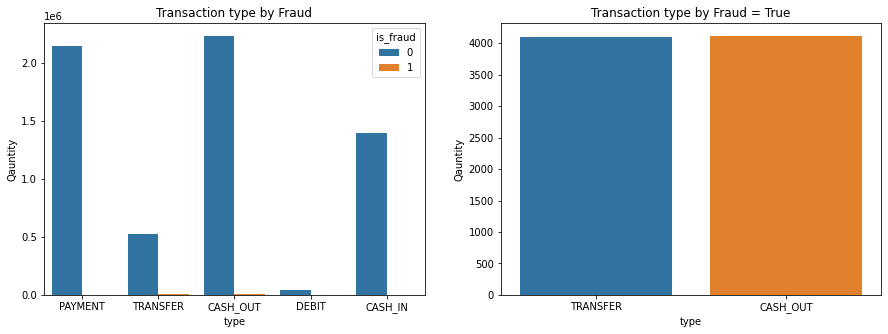

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='type', data=df4, hue='is_fraud')
plt.ylabel('Qauntity')
plt.title('Transaction type by Fraud')

plt.subplot(1, 2, 2)
filter_fraud = df4[df4['is_fraud'] == 1]
sns.countplot(x='type', data=filter_fraud)
plt.ylabel('Qauntity')
plt.title('Transaction type by Fraud = True');

### H2. Transações maiores que 50% do saldo bancario são fraudes.

**FALSA** A maior parte das transações que são maiores que 50% do saldo bancario, <ins>não</ins> são fraudes.

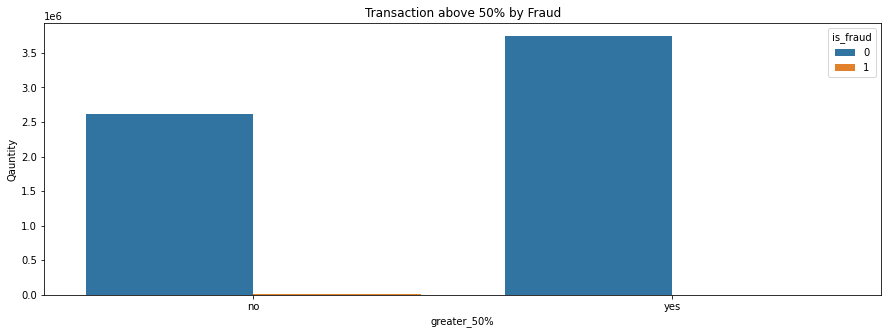

In [16]:
plt.figure(figsize=(15, 5))
sns.countplot(x='greater_50%', data=df4, hue='is_fraud')
plt.ylabel('Qauntity')
plt.title('Transaction above 50% by Fraud');

### H3. A maior parte de transações feitas superior que 80mil, são fraudes.

**VERDADEIRA** A maior parte das transações feitas sendo maiores que 80 mil, são fraudes.

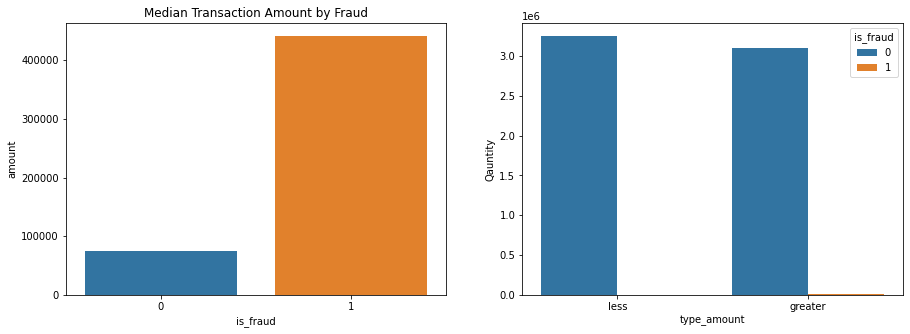

In [17]:
# Group median amount by fraud
median_group = df4['amount'].groupby(df['is_fraud']).median().reset_index()

# Figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='is_fraud', y='amount', data=median_group)
plt.title('Median Transaction Amount by Fraud')

# Figure 2
plt.subplot(1, 2, 2)
sns.countplot(x='type_amount', data=df4, hue='is_fraud')
plt.ylabel('Qauntity')
plt.title('');

### H4.  Contas de origem que ficaram zeradas após as transações, são fraudes.

**FALSA** A maior parte das transações em que o saldo final da conta de origem ficou zerada, não foi fraude.

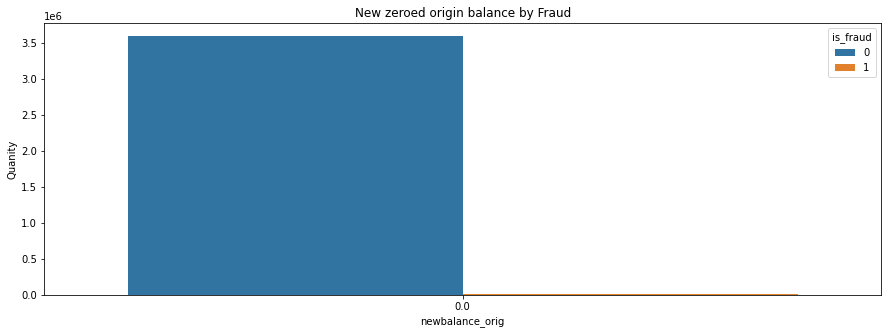

In [18]:
newbalance_orig_zero = df4[df4['newbalance_orig'] == 0]

plt.figure(figsize=(15, 5))
sns.countplot(x='newbalance_orig', data=newbalance_orig_zero, hue='is_fraud')
plt.ylabel('Quanity')
plt.title('New zeroed origin balance by Fraud');

### H5. <ins>Há maior quantidade de fraudes em contas de pessoas físicas.</ins> (VERIFICAR)

### H6. Há maior quantidade de fraudes em contas de pessoas com alto poder aquisitivo.

**VERDADEIRA** Há maior quantidade de fraudes em contas de pessoas com <ins>alto</ins> poder aquisitivo.

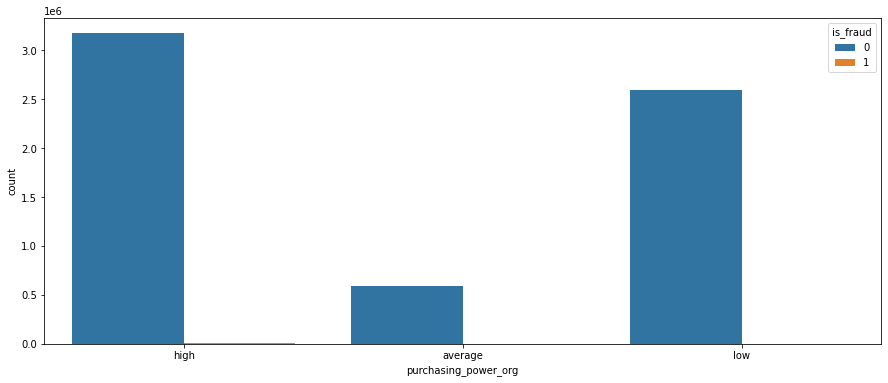

In [19]:
plt.figure(figsize=(15, 6))
sns.countplot(x='purchasing_power_org', data=df4, hue='is_fraud', order=['high', 'average', 'low']);

### H7. Há maior quantidade de fraudes em transações de pessoa física para juridica.

**FALSA** Há maior quantidade de fraudes em transações de <ins>clientes para clientes</ins>.

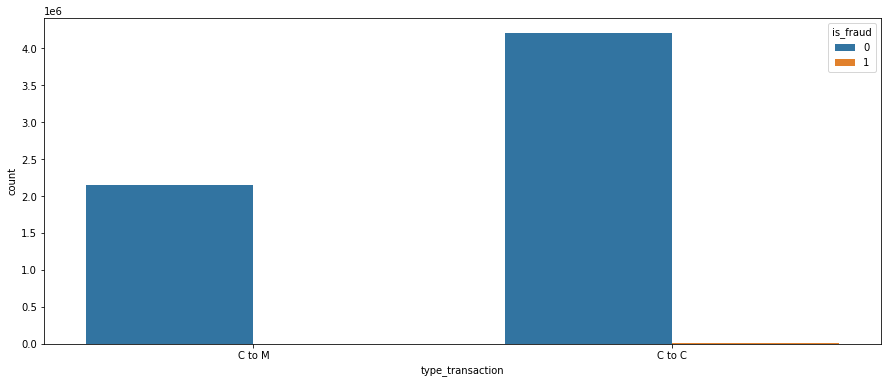

In [20]:
plt.figure(figsize=(15, 6))
sns.countplot(x='type_transaction', data=df4, hue='is_fraud');

## 4.3 Análise Multivariada

### 4.3.1 Variável Numérica

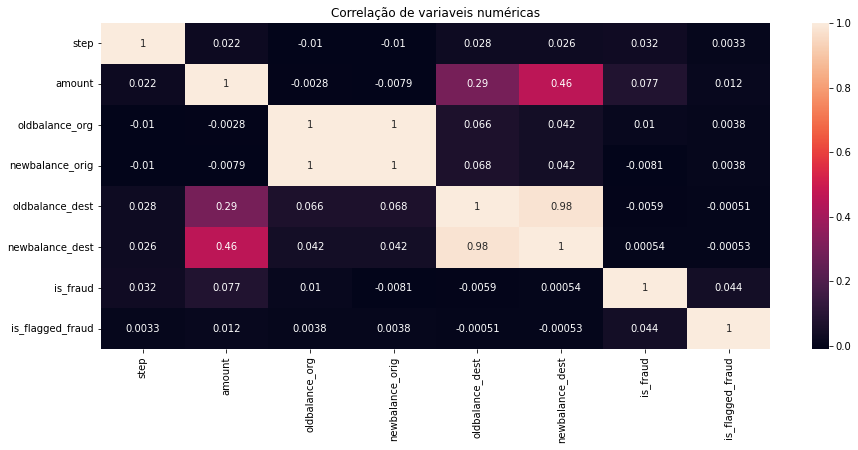

In [21]:
# filter numerical data
numerical = df4.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 6))
sns.heatmap(numerical.corr(method='pearson'), annot=True)
plt.title('Correlação de variaveis numéricas');

**Insight:**

Como já esperado, há correlações entre saldo do novo balanço e o antigo junto com valor da transaçãoom.

### 4.3.2 Variável Categórica

In [22]:
# Categorical data
categorical = df4.select_dtypes(include=['object'])

# Apply correlation categories
matrix = show_matrix(data=categorical, col='type', output='dict')
data_columns = categorical.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categorical, col=c, output='list')

# Figure
plt.figure(figsize=(15, 7))
sns.heatmap(matrix, annot=True)
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

KeyboardInterrupt: 

**Insight:**

# 5.0 PREPRAÇÃO DE DADOS

## 5.1 Reescalonamento

### 5.1.1 Min Max Scaler

A abordagem de Min Max Scaler transforma os dados para um intervalo entre 0 e 1. 

In [11]:
# Copy dataframe
df5 = df4.copy()

# Define method
mms = MinMaxScaler()

# step
df5['step'] = mms.fit_transform(df5[['step']].values)

### 5.1.2 Robust Scaler

A abordagem de Roboust Scaler transforma os dados para um intervalo entre o 1º quartil e o 3º.

In [12]:
# Define method
rs_amount = RobustScaler()
rs_oldbalance_org  = RobustScaler()
rs_newbalance_orig = RobustScaler()
rs_oldbalance_dest = RobustScaler()
rs_newbalance_dest = RobustScaler()

# amount
df5['amount'] = rs_amount.fit_transform(df5[['amount']].values)

# oldbalance_org
df5['oldbalance_org'] = rs_oldbalance_org.fit_transform(df5[['oldbalance_org']].values)

# newbalance_orig
df5['newbalance_orig'] = rs_newbalance_orig.fit_transform(df5[['newbalance_orig']].values)

# oldbalance_dest
df5['oldbalance_dest'] = rs_oldbalance_dest.fit_transform(df5[['oldbalance_dest']].values)

# newbalance_dest
df5['newbalance_dest'] = rs_newbalance_dest.fit_transform(df5[['newbalance_dest']].values)

## 5.2 Encoding

### 5.2.1 Label Encoding

In [13]:
# purchasing_power_org
df5['purchasing_power_org'] = df5['purchasing_power_org'].map({'high': 3, 'average': 2, 'low': 1})

# greater_50
df5['greater_50%'] = df5['greater_50%'].map({'no': 0, 'yes': 1})

# type_amount
df5['type_amount'] = df5['type_amount'].map({'less': 0, 'greater': 1})

### 5.2.2 One Hot Encoding

In [14]:
# type
df5 = pd.get_dummies(df5, prefix='type', columns=['type'])

# type_transaction
df5 = pd.get_dummies(df5, prefix='type_transaction', columns=['type_transaction'])

## 5.3 Divisão de Dados

### 5.3.1 Dados de Treinamento e Validação

In [15]:
y = df5['is_fraud'].copy() # target
x = df5.drop(columns='is_fraud').copy() # features

# Split data between train and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20)

# full training
training_full = pd.concat([x_train, y_train], axis=1)

### 5.3.2 Dados de Teste

In [16]:
test_size = 0.10
sample_size = round(training_full.shape[0] * test_size) 
test_full = training_full.sample(sample_size) # get sample

# training
training = training_full.drop(list(test_full.index))
x_train = training.drop(columns='is_fraud')
y_train = training['is_fraud']

# test
x_test = test_full.drop(columns='is_fraud')
y_test = test_full['is_fraud']

# 6.0 SELEÇÃO DE FEATURE

## 6.1 Low Variance

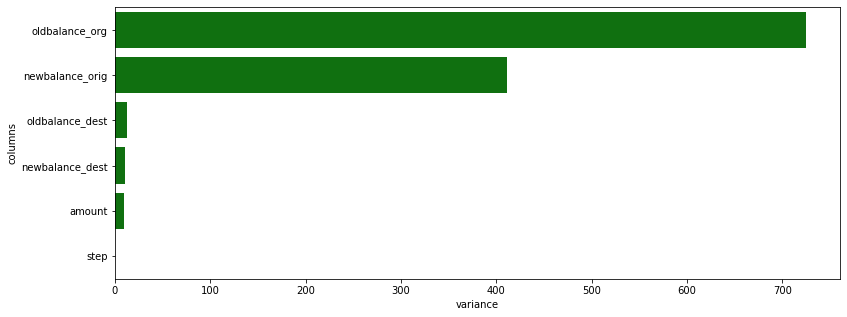

In [17]:
df6 = df5.copy()

numerical = df6.select_dtypes(include='float64')
plt.figure(figsize=(13, 5))
low_variance(numerical, 0.10)

## 6.2 Feature Importance

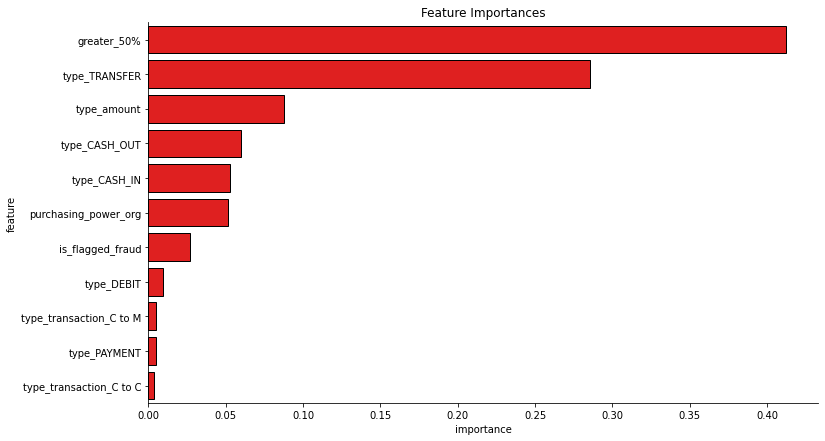

In [32]:
object_int = x.select_dtypes(include=['int64', 'uint8', 'object']).drop(columns=['name_orig', 'name_dest'])
#object_int = object_int.drop(columns=['name_orig', 'name_dest']).copy()

trees = ExtraTreesClassifier()
tree_training = trees.fit(object_int, y)

# Feature importance
importances = tree_training.feature_importances_
indices = np.argsort(importances)[::-1]

# Create dataframe with feature and importance
df = pd.DataFrame()
for i, j in zip(object_int, tree_training.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df  = pd.concat([df, aux], axis=0)

# Create figure to show feature importance    
df = df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(y='feature', x='importance', data=df, order=df['feature'], color='r', ec='k')
sns.despine(right=True)
plt.title('Feature Importances');

## 6.3 Filtragem de Feature

In [ ]:
cols_selected = ['oldbalance_org', 'newbalance_orig', 'greater_50%', 'type_TRANSFER',
                 'type_amount', 'type_CASH_OUT', 'type_CASH_IN', 'purchasing_power_org',
                 'is_flagged_fraud']

cols_selected_id = ['oldbalance_org', 'newbalance_orig', 'greater_50%', 'type_TRANSFER',
                    'type_amount', 'type_CASH_OUT', 'type_CASH_IN', 'purchasing_power_org',
                    'is_flagged_fraud', 'name_orig','name_dest']

# Filter columns selected
x_train = x_train[cols_selected_id]
x_val = x_val[cols_selected_id]
x_test = x_test[cols_selected_id]

# show feature importance columns selected
print('Columns Selected:', cols_selected)

# 7.0 MACHINE LEARNING

# 8.0 AJUSTE DE HIPERPARAMETROS

# 9.0 TRADUÇÃO E INTERPRETAÇÃO

# 10.0 DEPLOY MODELO

### + Dicionario de Dados


**step**: mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

**type:** Tipo da transação.

**amount:** valor da transação em moeda local.

**nameOrig:** cliente que iniciou a transação.

**oldbalanceOrg:** saldo inicial antes da transação.

**newbalanceOrig:** Saldo depois da transação.

**nameDest:** cliente que é o destinatário da transação.

**oldbalanceDest:** destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**newbalanceDest:** novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**isFraud:** Target.

**isFlaggedFraud:** O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.
